<a href="https://colab.research.google.com/github/AvantiShri/gcp_analysis_rough/blob/main/cleaner/BulkAnalyze_powerspectrum_welch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import Image
import scipy
import time

def get_relative_power_spectrum(signal):
  ps = np.square(np.abs(scipy.fft.rfft(signal)))
  #normalize to sum to 1
  return ps/np.sum(ps)

def get_psinfo_welch(signal, nperseg):
  freqs, ps = scipy.signal.welch(
    signal, nperseg=nperseg, window='boxcar', detrend=False, scaling='spectrum')

  #due to the symmetry property of the fourier transform for real-valued signals,
  # certain frequencies in the power spectrum
  # for real inputs have their power doubled. But we are interested in how the power
  # spectrum differs from a uniform power spectrum, so we need to undo that
  # doubling. Reference: https://github.com/scipy/scipy/blob/686422c4f0a71be1b4258309590fd3e9de102e18/scipy/signal/_spectral_py.py#L1900
  if nperseg%2: #if nperseg is odd
    ps[1:] /= 2
  else:
    ps[1:-1] /= 2

  ##Extract autocorrelation:
  autocovs = np.real(scipy.fft.irfft(ps*np.square(nperseg))) - ps[0]*nperseg #subtract ps[0]*nperseg to subtract (mean^2)*nperseg
  max_autocorr = np.max(autocovs[1:])/autocovs[0]

  return freqs, ps/np.sum(ps), max_autocorr

def max_over_different_smoothing_windows_1darr(arr, windowsizes):
  meannorm_arr = arr - np.mean(arr)
  meannormarr_cumsum = np.array([0] + list(np.cumsum(meannorm_arr)))
  #under the hypothesis of white noise, each entry is iid. Let v represent
  # the variance of each power. The variance of the sum in a window
  # is v*window, so the variances across different window sizes can be
  # normalized by dividing by sqrt(window).
  max_over_different_windowsizes = np.max([
      np.max((meannormarr_cumsum[windowsize:]
              - meannormarr_cumsum[:-windowsize]))/np.sqrt(windowsize)
      for windowsize in windowsizes])
  return max_over_different_windowsizes

def max_over_different_smoothing_windows_2darr(arrs, windowsizes):
  arrmeans = np.mean(arrs, axis=1)
  meannorm_arrs = arrs - arrmeans[:,None]
  meannormarrs_cumsum = np.pad(np.cumsum(meannorm_arrs, axis=1), ((0,0),(1,0)))
  max_over_different_windowsizes_arr = np.max([
      np.max((meannormarrs_cumsum[:,windowsize:]
              - meannormarrs_cumsum[:,:-windowsize]), axis=1)/np.sqrt(windowsize)
      for windowsize in windowsizes], axis=0)
  return max_over_different_windowsizes_arr

def perform_powerspectrum_analysis(values, num_permutations):

  toreturndict = {}

  start = time.time()
  rng = np.random.RandomState(1234)
  rng_permutations = np.array([rng.permutation(values)
                               for i in range(num_permutations)])

  #print("cp0", time.time()-start)
  for (nperseg, npersegname) in [(10, "10sec"), (20, "20sec"), (30, "30sec"), (60, "60sec")]:

    freqs, nps, max_autocorr = get_psinfo_welch(values, nperseg)
    entropy_nps = scipy.stats.entropy(nps)

    #permute the test data sequence num_permutations times to get an empirical null
    psinfos_permute = [ get_psinfo_welch(rng_permutation, nperseg)
                        for rng_permutation in rng_permutations ]

    nps_permute_2darr = np.array([ psinfo[1] for psinfo in psinfos_permute])
    maxautocorr_permute_arr = np.array([psinfo[2] for psinfo in psinfos_permute])
    entropy_nps_permute_arr = scipy.stats.entropy(nps_permute_2darr, axis=1)

    pval_entropy = np.mean(entropy_nps <= entropy_nps_permute_arr) #high entropy = uniform dist
    toreturndict['pval_nperseg-'+npersegname+'_entropy'] = pval_entropy

    uniform_expectation = 1.0/len(nps)

    expected_freq = np.sum(freqs*nps)
    expected_freq_permute_arr = np.sum(freqs[None,:]*nps_permute_2darr, axis=1)
    pval_ef = np.mean(expected_freq_permute_arr >= expected_freq)
    toreturndict['pval_nperseg-'+npersegname+'_ef'] = pval_ef

    maxd = np.max(np.abs(np.cumsum(nps - uniform_expectation)))
    maxd_permute_arr = np.max(np.abs(np.cumsum(nps_permute_2darr - uniform_expectation, axis=1)), axis=1);
    pval_maxd = np.mean(maxd_permute_arr >= maxd)
    toreturndict['pval_nperseg-'+npersegname+'_maxd'] = pval_maxd

    #freq_stepsize = freqs[1]
    #for smoothfreqwindows, smoothfreqwindowsname in [([x/10000 for x in range(50, 501, 25)], '50-500-25'),
    #                                                 ([x/10000 for x in range(100, 151, 25)], '100-150-25'),
    #                                                 ([x/10000 for x in range(125, 126, 25)], '125-125-25')]:
    #  windowsizes = [int(x/freq_stepsize) for x in smoothfreqwindows]
    #  max_smooth_nps = max_over_different_smoothing_windows_1darr(nps, windowsizes)
    #  max_smooth_nps_permute_2darr = max_over_different_smoothing_windows_2darr(
    #      nps_permute_2darr, windowsizes)
    #  pval_max_smooth = np.mean(max_smooth_nps_permute_2darr >= max_smooth_nps)
    #  toreturndict['pval_nperseg-'+npersegname+'_smooth'+smoothfreqwindowsname+'_maxsmooth'] = pval_max_smooth

  return (toreturndict, (freqs, nps))



In [2]:
def get_chisquareminus1(egg_values):
  #print("Num nan:", np.sum(np.isnan(egg_values)))
  #Radin 2023 (Anomalous entropic effects in physical systems associated
  # with collective consciousness) said "All individual samples within a matrix
  # less than 55 or greater than 145 were set to nan" so we do that here
  egg_values = np.where((egg_values < 55), np.nan, egg_values)
  egg_values = np.where((egg_values > 145), np.nan, egg_values)
  #print("Num nan post mask:", np.sum(np.isnan(egg_values)))

  num_nonnan_eggs = np.sum(np.isnan(egg_values)==False, axis=1) #get the number of non NaN eggs per row
  #If any rows are all-nan, aboort as if we dropped that row it would mess
  # up the temporal spacing
  #assert (np.sum(num_nonnan_eggs==0)==0), np.sum(num_nonnan_eggs==0)

  sum_eggs = np.nansum(egg_values, axis=1) #get the sum across all eggs - NaNs are automatically skipped
  z_sum_eggs = (sum_eggs - num_nonnan_eggs*100)/np.sqrt(num_nonnan_eggs*200*0.25) #get z scores as per a binomial dist

  return np.square(z_sum_eggs)-1, z_sum_eggs


In [3]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import json
event_metadata_list = json.load(open("/content/drive/MyDrive/GCP_data/event_metadata_list.json"))

In [ ]:
%matplotlib inline

import glob
import json
import numpy as np
import scipy
import os
from matplotlib import pyplot as plt
import time

%cd /content/drive/MyDrive/GCP_data/

NUM_PERMUTATIONS = 1000

generalstats = {"test": [], "control1": [], "control2": [], "control3": [],
                "control4": [], "control5": [], "control6": []}
#csm1_psanalysis = {"test": [], "control1": [], "control2": [], "control3": [],
#                   "control4": [], "control5": [], "control6": []}
compositez_psanalysis = {"test": [], "control1": [], "control2": [],
                         "control3": [], "control4": [], "control5": [], "control6": []}

event_count = 0

dont_rerun_if_cache_file_exists = True #If False, rerun the call the perform_powerspectrum_analysis
cachesavefolder = "/content/drive/MyDrive/GCP_data/analysis/pswelch10to60sec/"
!mkdir $cachesavefolder

for (event, event_name, pval) in event_metadata_list[:]:

  event_count += 1
  print("\n--------------------------------")
  print("Event Count:",event_count,event,event_name,pval)

  for spanname in ['test', 'control1', 'control2', 'control3',
                           'control4', 'control5', 'control6']:
    print("span:", spanname)
    egg_values = np.load("extracted/"+event+"_"+spanname+"_eggvalues.npy")

    csm1, z_sum_eggs = get_chisquareminus1(egg_values)

    csm1_zscore = np.sum(csm1)/np.sqrt(2*len(csm1)) #variance of chi-squared with df=1 is 2

    spangeneralstats = {
      'csm1_zscore': csm1_zscore,
      'length': len(csm1)}
    generalstats[spanname].append(spangeneralstats)

    print(spanname, spangeneralstats)

    for signaltype,signal,signalsavedict in [#("csm1", csm1, csm1_psanalysis),
                                             ("compositez", z_sum_eggs, compositez_psanalysis)
                                             ]:
      start = time.time()
      saveprefix = cachesavefolder+"/"+event+"_"+spanname+"_"+signaltype+"_nperm-"+str(NUM_PERMUTATIONS)
      if (dont_rerun_if_cache_file_exists and os.path.exists(saveprefix+"_psanalysis.json")):
        ps_analysis = json.load(open(saveprefix+"_psanalysis.json"))
      else:
        ps_analysis, _ = perform_powerspectrum_analysis(signal, NUM_PERMUTATIONS)
        open(saveprefix+"_psanalysis.json",'w').write(json.dumps(ps_analysis))
      print(signaltype, ps_analysis, time.time()-start)
      signalsavedict[spanname].append(ps_analysis)


Streaming output truncated to the last 5000 lines.
control4 {'csm1_zscore': -1.2359766823030487, 'length': 86400}
compositez {'pval_nperseg-10sec_entropy': 0.43, 'pval_nperseg-10sec_ef': 0.571, 'pval_nperseg-10sec_maxd': 0.695, 'pval_nperseg-20sec_entropy': 0.281, 'pval_nperseg-20sec_ef': 0.572, 'pval_nperseg-20sec_maxd': 0.763, 'pval_nperseg-30sec_entropy': 0.094, 'pval_nperseg-30sec_ef': 0.462, 'pval_nperseg-30sec_maxd': 0.587, 'pval_nperseg-60sec_entropy': 0.264, 'pval_nperseg-60sec_ef': 0.3, 'pval_nperseg-60sec_maxd': 0.701} 0.2750864028930664
span: control5
control5 {'csm1_zscore': -1.552062926392241, 'length': 86400}
compositez {'pval_nperseg-10sec_entropy': 0.022, 'pval_nperseg-10sec_ef': 0.422, 'pval_nperseg-10sec_maxd': 0.983, 'pval_nperseg-20sec_entropy': 0.02, 'pval_nperseg-20sec_ef': 0.464, 'pval_nperseg-20sec_maxd': 0.988, 'pval_nperseg-30sec_entropy': 0.004, 'pval_nperseg-30sec_ef': 0.545, 'pval_nperseg-30sec_maxd': 0.993, 'pval_nperseg-60sec_entropy': 0.335, 'pval_nperse

In [5]:
import json

prefix = "/content/drive/MyDrive/GCP_data/analysis/nperm"+str(NUM_PERMUTATIONS)+"_pswelch10to60sec_controls1to6"

#save the results
#open(prefix+"_csm1_psanalysis.json","w").write(json.dumps(csm1_psanalysis, indent=4))
open(prefix+"_compositez_psanalysis.json","w").write(json.dumps(compositez_psanalysis, indent=4))

NameError: ignored

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GCP_data

In [6]:
import json
import numpy as np
import scipy

NUM_PERMUTATIONS = 1000

#load the pvals in case we want to remake the plots without rerunning the prev stuff
prefix = "/content/drive/MyDrive/GCP_data/analysis/nperm"+str(NUM_PERMUTATIONS)+"_pswelch10to60sec_controls1to6"

event_metadata_list = json.load(open("/content/drive/MyDrive/GCP_data/event_metadata_list.json"))
#generalstats = json.load(open("/content/drive/MyDrive/GCP_data/analysis/generalstats.json"))

#csm1_psanalysis = json.load(open(prefix+"_csm1_psanalysis.json"))
compositez_psanalysis = json.load(open(prefix+"_compositez_psanalysis.json"))

In [7]:
import os

def get_meta_pval(pvals):
  chisquare_stat = -2*np.sum(np.log(pvals))
  deg_freedom = 2*len(pvals)
  return (1 - scipy.stats.chi2.cdf(chisquare_stat, df=deg_freedom))

def get_iterative_metapvals(pvals):
 return np.array([(get_meta_pval(pvals[:i+1])) for i in range(len(pvals))])

metatrends_to_sim = 5000
rng = np.random.RandomState(1234)
savefile = "/content/drive/MyDrive/GCP_data/analysis/simulated_metatrends_nperm"+str(metatrends_to_sim)+".npy"
if (os.path.isfile(savefile)):
  simulated_metapvals_arr = np.load(savefile)
else:
  simulated_metapvals_arr = np.array([
      get_iterative_metapvals(
        np.maximum(rng.uniform(size=len(event_metadata_list)),
                  1.0/NUM_PERMUTATIONS)
      )
        for i in range(metatrends_to_sim)])
  np.save(savefile, simulated_metapvals_arr)

In [8]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from IPython.core.display import Image, display

#plot how the meta pvalue changes with samples

min_meta = 1 # start the x axis here, min num to include in metaanalysis
max_meta = len(event_metadata_list) #where to stop the plot

def correct_pvals(pvals, m): #permutation p values should never be zero: https://www.degruyter.com/document/doi/10.2202/1544-6115.1585/html
  #'Let B be the number of times out of m that t_sim >= t_obs'
  Bs = pvals*m
  #Under the null hypothesis, B is uniformly distributed across all integers
  # ranging from 0 to m, and the probability of observing B <= b is (b+1)/(m+1)
  adjusted_pvals = (Bs+1)/(m+1)
  return adjusted_pvals

original_gcp_pvals = np.array([x[2] for x in event_metadata_list[:max_meta]])

def make_meta_trend_plot(title, uncorrected_pvals_loa, loa_names, loa_colors):
  %matplotlib inline

  xaxis_slice = list(range(min_meta,max_meta+1))
  xaxis_full = list(range(1,max_meta+1))

  pvals_loa = [correct_pvals(arr, m=NUM_PERMUTATIONS) for arr in uncorrected_pvals_loa]
  metapvals_loa = [get_iterative_metapvals(arr) for arr in pvals_loa]

  theslice = slice(min_meta-1, max_meta)
  min_simmetapvals_arr = np.min(simulated_metapvals_arr[:,theslice], axis=1)

  pvalformetapvals_list = [correct_pvals(np.mean(min_simmetapvals_arr <= np.min(arr)),
                                         m=len(simulated_metapvals_arr))
                            for arr in metapvals_loa]

  pvalforrankbias_list = [
      scipy.stats.mannwhitneyu(x=arr[original_gcp_pvals < 0.5],
                               y=arr[original_gcp_pvals >= 0.5], alternative='less')[1]
      for arr in pvals_loa
  ]
  print("Testing for low meta-analysis p-values:")
  for arr_name, metatrendpval, rankbiaspval in zip(loa_names, pvalformetapvals_list, pvalforrankbias_list):
    print("meta-analysis p-value:",arr_name,"pval:",metatrendpval)
    print("Rankbias p-value:",arr_name,"pval:",rankbiaspval)

  #Plot meta-analysis trends for the original pvalues
  fig = plt.figure(figsize=(15,4))
  handles = []

  plt.plot([min_meta, max_meta], -np.log10([np.percentile(min_simmetapvals_arr, 5)]*2), color="black", linestyle="--")
  plt.plot(xaxis_full, -np.log10(original_gcp_pvals), color="black")
  handles.append(mpatches.Patch(color='black', label='Original GCP -log10(pval)'))

  for pvals, metapvals, color, arr_name in zip(pvals_loa, metapvals_loa, loa_colors, loa_names):
    plt.scatter(xaxis_full, -np.log10(pvals[:max_meta]), color=color, s=1)
    plt.plot(xaxis_slice, -np.log10(metapvals[theslice]), color=color)
    handles.append(mpatches.Patch(color=color, label=arr_name))

  plt.xlabel("Event Number (top ranked first)")
  plt.ylabel("-log10 pvalue") #Z-score equivalent derived from inverse-normal-cdf(1-p)
  plt.title(title)
  plt.legend(handles=handles, loc="upper left", ncol=4)
  plt.show()

  return pvalformetapvals_list

print("num permutations:",NUM_PERMUTATIONS)

num permutations: 1000


compositez
nperseg-10sec_entropy
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.4351129774045191
Rankbias p-value: Original Timeperiod pval: 0.28597277936787846
meta-analysis p-value: 1x before pval: 0.39392121575684863
Rankbias p-value: 1x before pval: 0.34138928299432086
meta-analysis p-value: 1x after pval: 0.16396720655868827
Rankbias p-value: 1x after pval: 0.9127404733540998
meta-analysis p-value: 2x before pval: 0.8614277144571085
Rankbias p-value: 2x before pval: 0.8017840961248587
meta-analysis p-value: 2x after pval: 0.9336132773445311
Rankbias p-value: 2x after pval: 0.05335168651498179
meta-analysis p-value: 3x before pval: 0.1749650069986003
Rankbias p-value: 3x before pval: 0.829541108453054
meta-analysis p-value: 3x after pval: 0.29994001199760045
Rankbias p-value: 3x after pval: 0.8587107287340702


nperseg-20sec_entropy
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.381123775244951
Rankbias p-value: Original Timeperiod pval: 0.44124303277475896
meta-analysis p-value: 1x before pval: 0.7210557888422315
Rankbias p-value: 1x before pval: 0.2126634356426757
meta-analysis p-value: 1x after pval: 0.07058588282343531
Rankbias p-value: 1x after pval: 0.5355545510944536
meta-analysis p-value: 2x before pval: 0.06938612277544491
Rankbias p-value: 2x before pval: 0.6076551251918587
meta-analysis p-value: 2x after pval: 0.968006398720256
Rankbias p-value: 2x after pval: 0.3722721030841491
meta-analysis p-value: 3x before pval: 0.891621675664867
Rankbias p-value: 3x before pval: 0.5074850567677403
meta-analysis p-value: 3x after pval: 0.1289742051589682
Rankbias p-value: 3x after pval: 0.9536996501524528


nperseg-30sec_entropy
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.6492701459708058
Rankbias p-value: Original Timeperiod pval: 0.09474984093038191
meta-analysis p-value: 1x before pval: 0.9608078384323135
Rankbias p-value: 1x before pval: 0.5142376576610146
meta-analysis p-value: 1x after pval: 0.7950409918016397
Rankbias p-value: 1x after pval: 0.7667268367550615
meta-analysis p-value: 2x before pval: 0.5874825034993001
Rankbias p-value: 2x before pval: 0.8088426390409074
meta-analysis p-value: 2x after pval: 0.9476104779044191
Rankbias p-value: 2x after pval: 0.45554463459072414
meta-analysis p-value: 3x before pval: 0.6100779844031193
Rankbias p-value: 3x before pval: 0.19936493939004762
meta-analysis p-value: 3x after pval: 0.32533493301339733
Rankbias p-value: 3x after pval: 0.8523645647840429


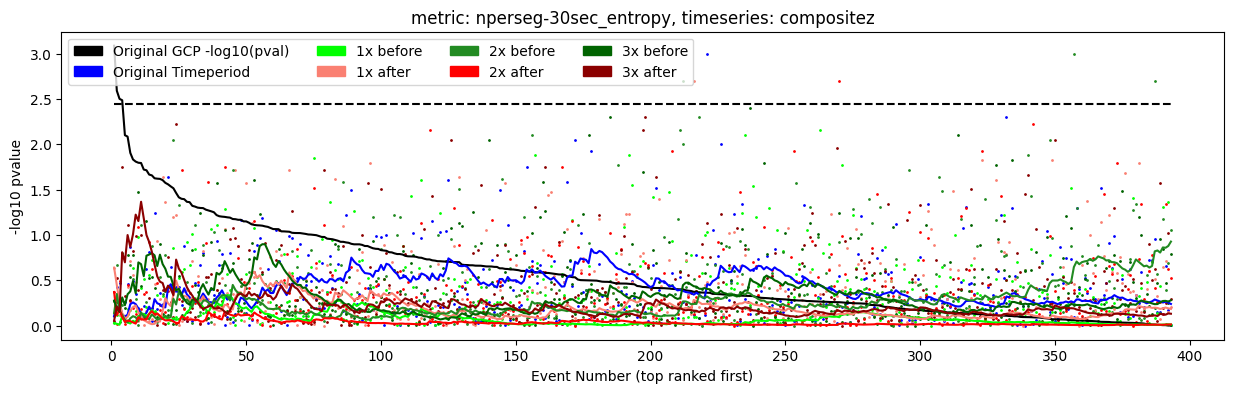

nperseg-60sec_entropy
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.10657868426314737
Rankbias p-value: Original Timeperiod pval: 0.11804124300338542
meta-analysis p-value: 1x before pval: 0.936612677464507
Rankbias p-value: 1x before pval: 0.48703959947434616
meta-analysis p-value: 1x after pval: 0.250749850029994
Rankbias p-value: 1x after pval: 0.9037750579175615
meta-analysis p-value: 2x before pval: 0.78624275144971
Rankbias p-value: 2x before pval: 0.763634245109585
meta-analysis p-value: 2x after pval: 0.6470705858828234
Rankbias p-value: 2x after pval: 0.6765596817845572
meta-analysis p-value: 3x before pval: 0.3189362127574485
Rankbias p-value: 3x before pval: 0.38427808314822426
meta-analysis p-value: 3x after pval: 0.9194161167766447
Rankbias p-value: 3x after pval: 0.8419956878469763


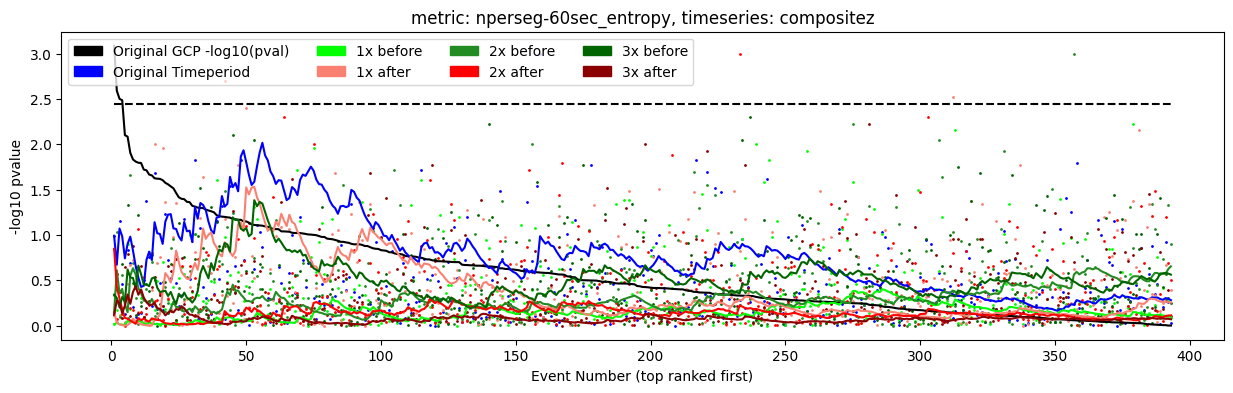

nperseg-10sec_ef
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.35872825434913014
Rankbias p-value: Original Timeperiod pval: 0.7566655097810105
meta-analysis p-value: 1x before pval: 0.39072185562887424
Rankbias p-value: 1x before pval: 0.45228024235494707
meta-analysis p-value: 1x after pval: 0.3141371725654869
Rankbias p-value: 1x after pval: 0.29569785768187373
meta-analysis p-value: 2x before pval: 0.041591681663667265
Rankbias p-value: 2x before pval: 0.3967488105094641
meta-analysis p-value: 2x after pval: 0.8264347130573885
Rankbias p-value: 2x after pval: 0.6916951306510993
meta-analysis p-value: 3x before pval: 0.7458508298340332
Rankbias p-value: 3x before pval: 0.11813169891383862
meta-analysis p-value: 3x after pval: 0.39632073585282945
Rankbias p-value: 3x after pval: 0.17739085762115236


nperseg-20sec_ef
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.20935812837432513
Rankbias p-value: Original Timeperiod pval: 0.6111683500856185
meta-analysis p-value: 1x before pval: 0.47590481903619275
Rankbias p-value: 1x before pval: 0.36760706776264973
meta-analysis p-value: 1x after pval: 0.20855828834233153
Rankbias p-value: 1x after pval: 0.23215454449128592
meta-analysis p-value: 2x before pval: 0.0649870025994801
Rankbias p-value: 2x before pval: 0.42092323157233075
meta-analysis p-value: 2x after pval: 0.7518496300739852
Rankbias p-value: 2x after pval: 0.8291930831113035
meta-analysis p-value: 3x before pval: 0.5672865426914617
Rankbias p-value: 3x before pval: 0.1858432494267399
meta-analysis p-value: 3x after pval: 0.29154169166166766
Rankbias p-value: 3x after pval: 0.20542919266066273


nperseg-30sec_ef
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.4011197760447911
Rankbias p-value: Original Timeperiod pval: 0.6092370803734022
meta-analysis p-value: 1x before pval: 0.5106978604279145
Rankbias p-value: 1x before pval: 0.6104664390091836
meta-analysis p-value: 1x after pval: 0.41471705658868224
Rankbias p-value: 1x after pval: 0.21600040184583447
meta-analysis p-value: 2x before pval: 0.04879024195160968
Rankbias p-value: 2x before pval: 0.2897193077988125
meta-analysis p-value: 2x after pval: 0.5056988602279545
Rankbias p-value: 2x after pval: 0.7830598855404176
meta-analysis p-value: 3x before pval: 0.643871225754849
Rankbias p-value: 3x before pval: 0.1667727316864373
meta-analysis p-value: 3x after pval: 0.5356928614277144
Rankbias p-value: 3x after pval: 0.3039693955931603


nperseg-60sec_ef
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.3985202959408118
Rankbias p-value: Original Timeperiod pval: 0.6691279442300947
meta-analysis p-value: 1x before pval: 0.5260947810437913
Rankbias p-value: 1x before pval: 0.44901916942683734
meta-analysis p-value: 1x after pval: 0.33513297340531895
Rankbias p-value: 1x after pval: 0.13109650302869869
meta-analysis p-value: 2x before pval: 0.01919616076784643
Rankbias p-value: 2x before pval: 0.28317820023772655
meta-analysis p-value: 2x after pval: 0.5448910217956408
Rankbias p-value: 2x after pval: 0.8019115507155196
meta-analysis p-value: 3x before pval: 0.5198960207958409
Rankbias p-value: 3x before pval: 0.12299937415865664
meta-analysis p-value: 3x after pval: 0.3287342531493701
Rankbias p-value: 3x after pval: 0.3335309459549455


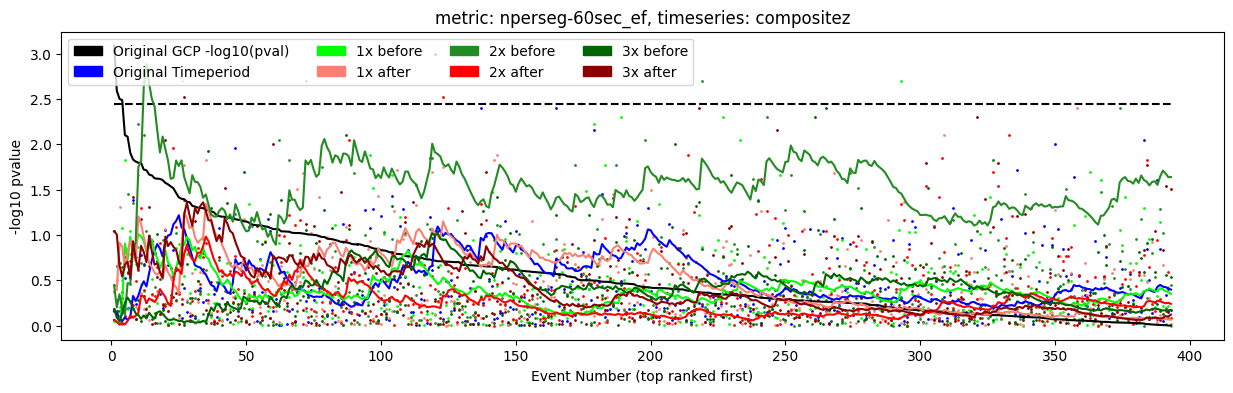

nperseg-10sec_maxd
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.8350329934013198
Rankbias p-value: Original Timeperiod pval: 0.6020157976701285
meta-analysis p-value: 1x before pval: 0.47750449910017995
Rankbias p-value: 1x before pval: 0.6636349032422206
meta-analysis p-value: 1x after pval: 0.16876624675064986
Rankbias p-value: 1x after pval: 0.04219438530815984
meta-analysis p-value: 2x before pval: 0.15296940611877624
Rankbias p-value: 2x before pval: 0.06607938851039079
meta-analysis p-value: 2x after pval: 0.7094581083783243
Rankbias p-value: 2x after pval: 0.929768149527645
meta-analysis p-value: 3x before pval: 0.4191161767646471
Rankbias p-value: 3x before pval: 0.34526014123652393
meta-analysis p-value: 3x after pval: 0.3735252949410118
Rankbias p-value: 3x after pval: 0.10736409985008033


nperseg-20sec_maxd
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.8398320335932813
Rankbias p-value: Original Timeperiod pval: 0.5713662291083843
meta-analysis p-value: 1x before pval: 0.826634673065387
Rankbias p-value: 1x before pval: 0.3911143709527643
meta-analysis p-value: 1x after pval: 0.5056988602279545
Rankbias p-value: 1x after pval: 0.38672807055360714
meta-analysis p-value: 2x before pval: 0.23775244951009797
Rankbias p-value: 2x before pval: 0.26789514296571104
meta-analysis p-value: 2x after pval: 0.47850429914017195
Rankbias p-value: 2x after pval: 0.4273766920307013
meta-analysis p-value: 3x before pval: 0.2429514097180564
Rankbias p-value: 3x before pval: 0.44341092575180696
meta-analysis p-value: 3x after pval: 0.34233153369326136
Rankbias p-value: 3x after pval: 0.02636055696277854


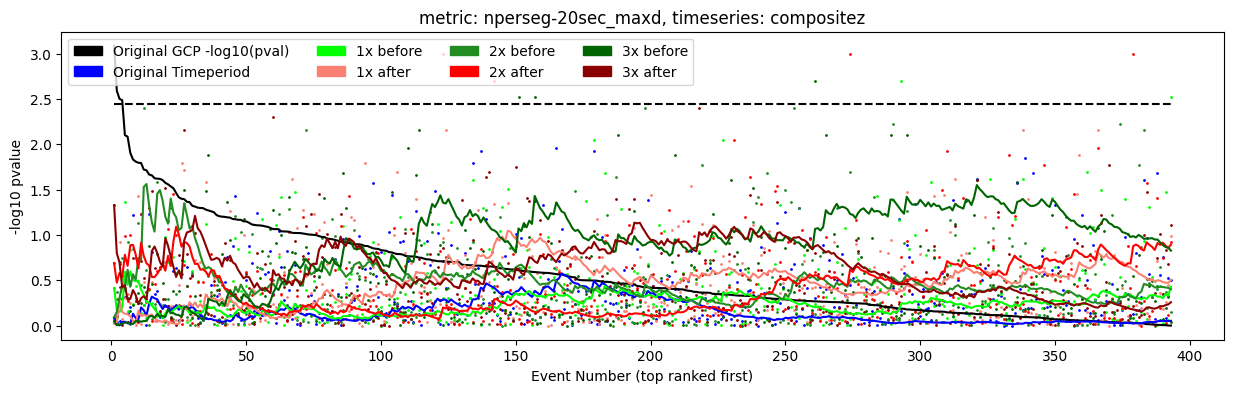

nperseg-30sec_maxd
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.9826034793041392
Rankbias p-value: Original Timeperiod pval: 0.8025479533000732
meta-analysis p-value: 1x before pval: 0.5238952209558089
Rankbias p-value: 1x before pval: 0.6629666300808019
meta-analysis p-value: 1x after pval: 0.2695460907818436
Rankbias p-value: 1x after pval: 0.3240981404245986
meta-analysis p-value: 2x before pval: 0.40671865626874626
Rankbias p-value: 2x before pval: 0.3720989762511455
meta-analysis p-value: 2x after pval: 0.5126974605078983
Rankbias p-value: 2x after pval: 0.5018257202013193
meta-analysis p-value: 3x before pval: 0.2959408118376325
Rankbias p-value: 3x before pval: 0.43817475398879113
meta-analysis p-value: 3x after pval: 0.42391521695660866
Rankbias p-value: 3x after pval: 0.08186961654818042


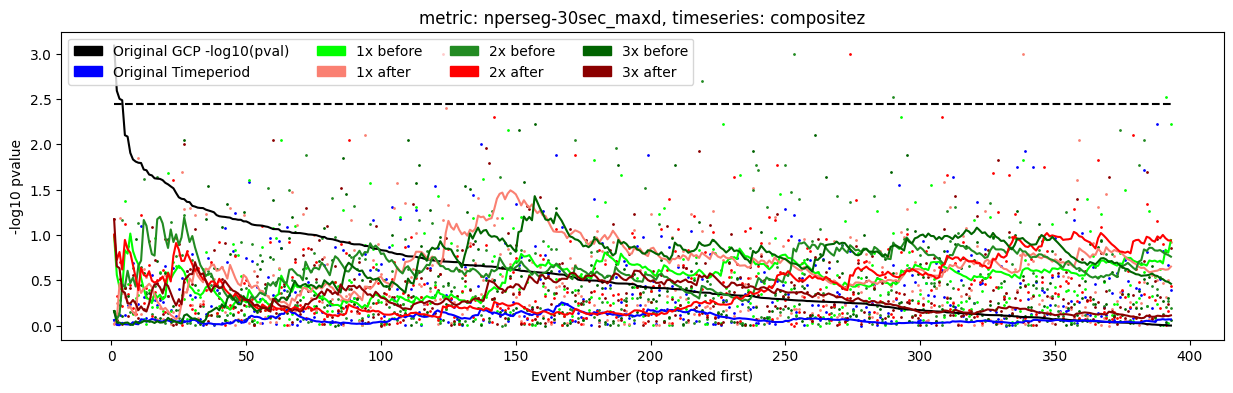

nperseg-60sec_maxd
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.9594081183763248
Rankbias p-value: Original Timeperiod pval: 0.7524896775689527
meta-analysis p-value: 1x before pval: 0.5356928614277144
Rankbias p-value: 1x before pval: 0.3350303384536798
meta-analysis p-value: 1x after pval: 0.29054189162167565
Rankbias p-value: 1x after pval: 0.21519703393356865
meta-analysis p-value: 2x before pval: 0.17476504699060189
Rankbias p-value: 2x before pval: 0.1185850273844351
meta-analysis p-value: 2x after pval: 0.5306938612277544
Rankbias p-value: 2x after pval: 0.8340271943920123
meta-analysis p-value: 3x before pval: 0.3987202559488102
Rankbias p-value: 3x before pval: 0.5142376653984457
meta-analysis p-value: 3x after pval: 0.28934213157368527
Rankbias p-value: 3x after pval: 0.018889722701562594


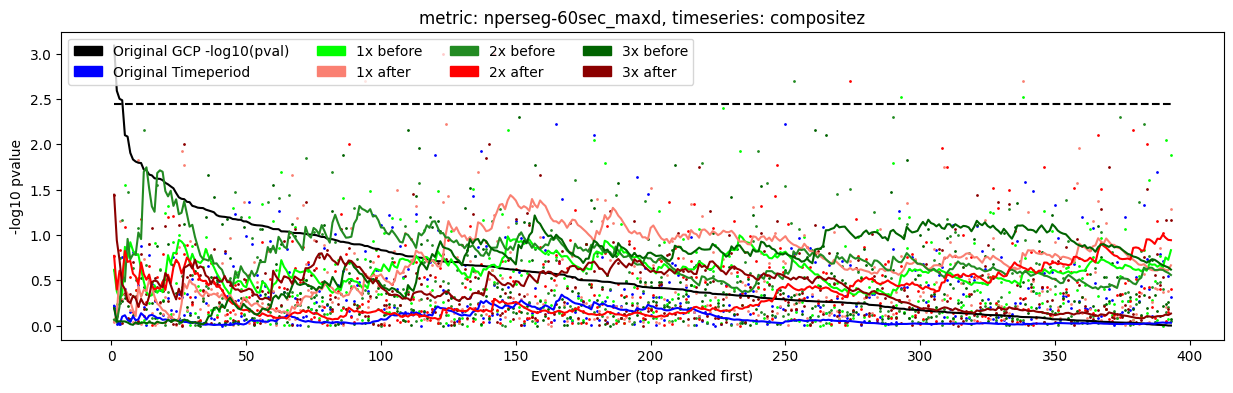

compositez
NEGATIVE nperseg-10sec_entropy
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.8448310337932413
Rankbias p-value: Original Timeperiod pval: 0.7143383843434087
meta-analysis p-value: 1x before pval: 0.1923615276944611
Rankbias p-value: 1x before pval: 0.658946545874749
meta-analysis p-value: 1x after pval: 0.3767246550689862
Rankbias p-value: 1x after pval: 0.0874048662892607
meta-analysis p-value: 2x before pval: 0.28754249150169964
Rankbias p-value: 2x before pval: 0.19847086803163416
meta-analysis p-value: 2x after pval: 0.6650669866026795
Rankbias p-value: 2x after pval: 0.9467476356148247
meta-analysis p-value: 3x before pval: 0.8288342331533693
Rankbias p-value: 3x before pval: 0.17069100900178885
meta-analysis p-value: 3x after pval: 0.3207358528294341
Rankbias p-value: 3x after pval: 0.1414943646767578


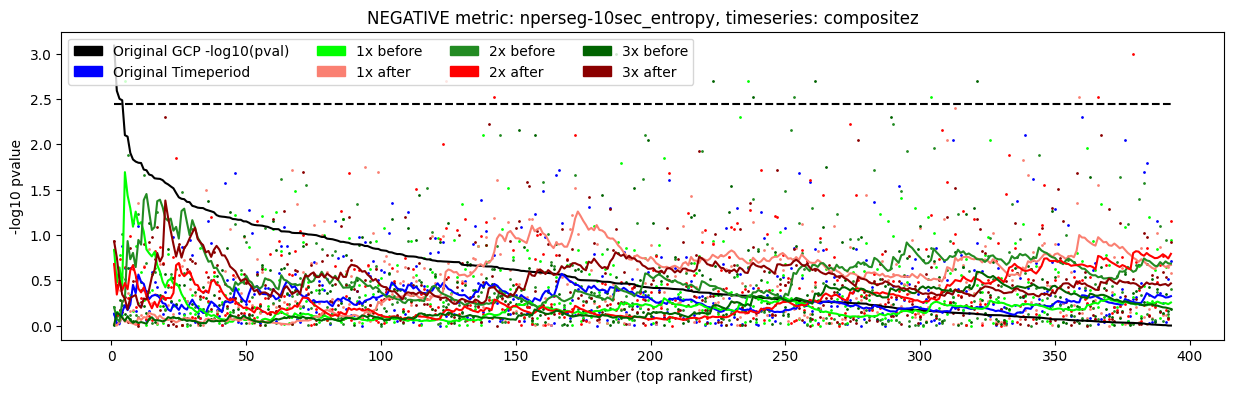

NEGATIVE nperseg-20sec_entropy
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.8544291141771646
Rankbias p-value: Original Timeperiod pval: 0.5591181208265361
meta-analysis p-value: 1x before pval: 0.5562887422515497
Rankbias p-value: 1x before pval: 0.7876022085497132
meta-analysis p-value: 1x after pval: 0.2635472905418917
Rankbias p-value: 1x after pval: 0.46480915876176687
meta-analysis p-value: 2x before pval: 0.3809238152369527
Rankbias p-value: 2x before pval: 0.3926966877409991
meta-analysis p-value: 2x after pval: 0.585882823435313
Rankbias p-value: 2x after pval: 0.6280741125311794
meta-analysis p-value: 3x before pval: 0.6518696260747852
Rankbias p-value: 3x before pval: 0.49288002818958687
meta-analysis p-value: 3x after pval: 0.5198960207958409
Rankbias p-value: 3x after pval: 0.046389184839203394


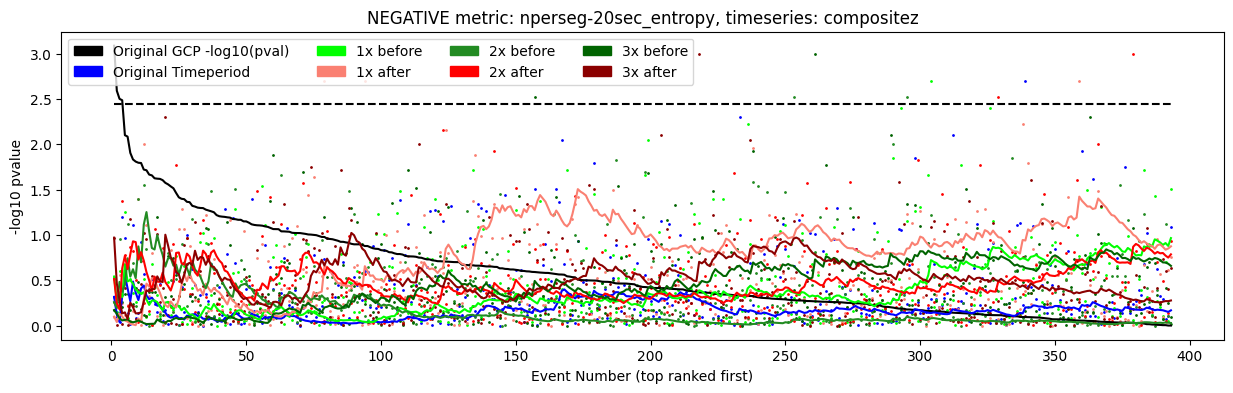

NEGATIVE nperseg-30sec_entropy
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.7822435512897421
Rankbias p-value: Original Timeperiod pval: 0.905404466137454
meta-analysis p-value: 1x before pval: 0.4405118976204759
Rankbias p-value: 1x before pval: 0.4861272613628611
meta-analysis p-value: 1x after pval: 0.3317336532693461
Rankbias p-value: 1x after pval: 0.23355337874863302
meta-analysis p-value: 2x before pval: 0.6412717456508699
Rankbias p-value: 2x before pval: 0.19140676483609398
meta-analysis p-value: 2x after pval: 0.2495500899820036
Rankbias p-value: 2x after pval: 0.544818223053233
meta-analysis p-value: 3x before pval: 0.8350329934013198
Rankbias p-value: 3x before pval: 0.8008907166134652
meta-analysis p-value: 3x after pval: 0.5974805038992201
Rankbias p-value: 3x after pval: 0.14784668902831777


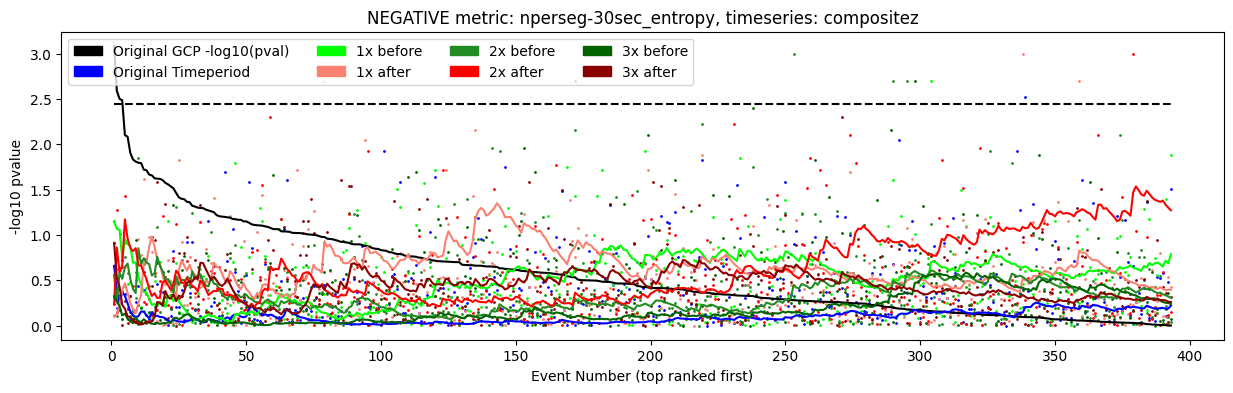

NEGATIVE nperseg-60sec_entropy
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.9698060387922416
Rankbias p-value: Original Timeperiod pval: 0.8821396374370978
meta-analysis p-value: 1x before pval: 0.15216956608678264
Rankbias p-value: 1x before pval: 0.513325348290091
meta-analysis p-value: 1x after pval: 0.10957808438312337
Rankbias p-value: 1x after pval: 0.096381200644444
meta-analysis p-value: 2x before pval: 0.7306538692261547
Rankbias p-value: 2x before pval: 0.23664801652823247
meta-analysis p-value: 2x after pval: 0.28334333133373324
Rankbias p-value: 2x after pval: 0.3237691605029286
meta-analysis p-value: 3x before pval: 0.9548090381923615
Rankbias p-value: 3x before pval: 0.6160715435900351
meta-analysis p-value: 3x after pval: 0.8228354329134173
Rankbias p-value: 3x after pval: 0.15822528887952048


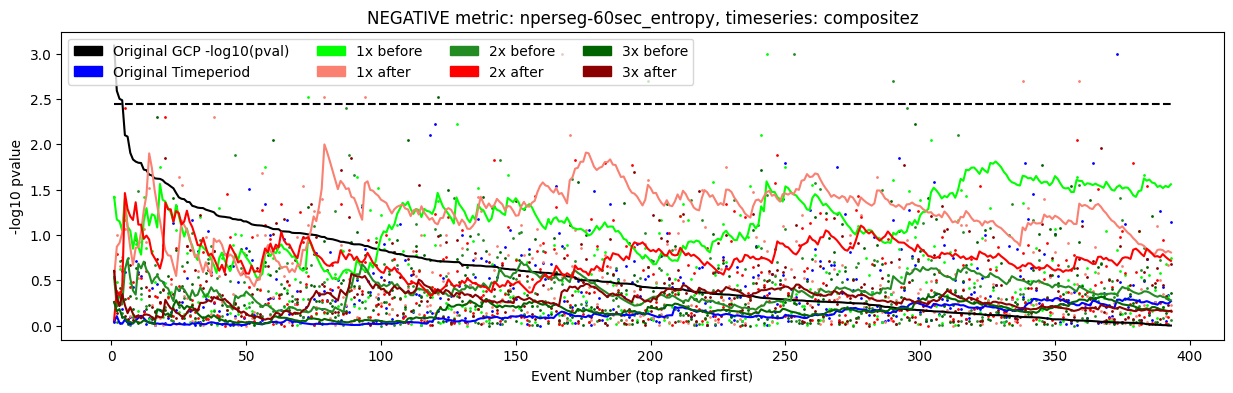

NEGATIVE nperseg-10sec_ef
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.9404119176164767
Rankbias p-value: Original Timeperiod pval: 0.24362125833686826
meta-analysis p-value: 1x before pval: 0.5826834633073386
Rankbias p-value: 1x before pval: 0.5480822683389548
meta-analysis p-value: 1x after pval: 0.4407118576284743
Rankbias p-value: 1x after pval: 0.7046182130577587
meta-analysis p-value: 2x before pval: 0.8462307538492302
Rankbias p-value: 2x before pval: 0.6036039942408564
meta-analysis p-value: 2x after pval: 0.6332733453309338
Rankbias p-value: 2x after pval: 0.3086270767406397
meta-analysis p-value: 3x before pval: 0.6026794641071785
Rankbias p-value: 3x before pval: 0.8820492796330464
meta-analysis p-value: 3x after pval: 0.8298340331933614
Rankbias p-value: 3x after pval: 0.8228470147595485


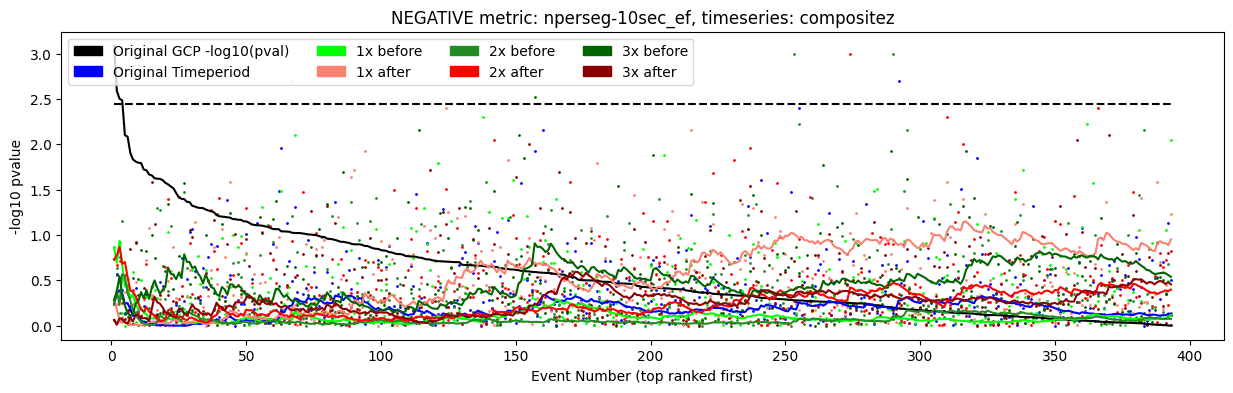

NEGATIVE nperseg-20sec_ef
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.9006198760247951
Rankbias p-value: Original Timeperiod pval: 0.38918257088313846
meta-analysis p-value: 1x before pval: 0.4839032193561288
Rankbias p-value: 1x before pval: 0.6327377283087807
meta-analysis p-value: 1x after pval: 0.44991001799640074
Rankbias p-value: 1x after pval: 0.768124736290807
meta-analysis p-value: 2x before pval: 0.9068186362727455
Rankbias p-value: 2x before pval: 0.5794346847686347
meta-analysis p-value: 2x after pval: 0.5566886622675465
Rankbias p-value: 2x after pval: 0.17103933769419444
meta-analysis p-value: 3x before pval: 0.5972805438912216
Rankbias p-value: 3x before pval: 0.8144016578049398
meta-analysis p-value: 3x after pval: 0.7340531893621276
Rankbias p-value: 3x after pval: 0.7948310887205279


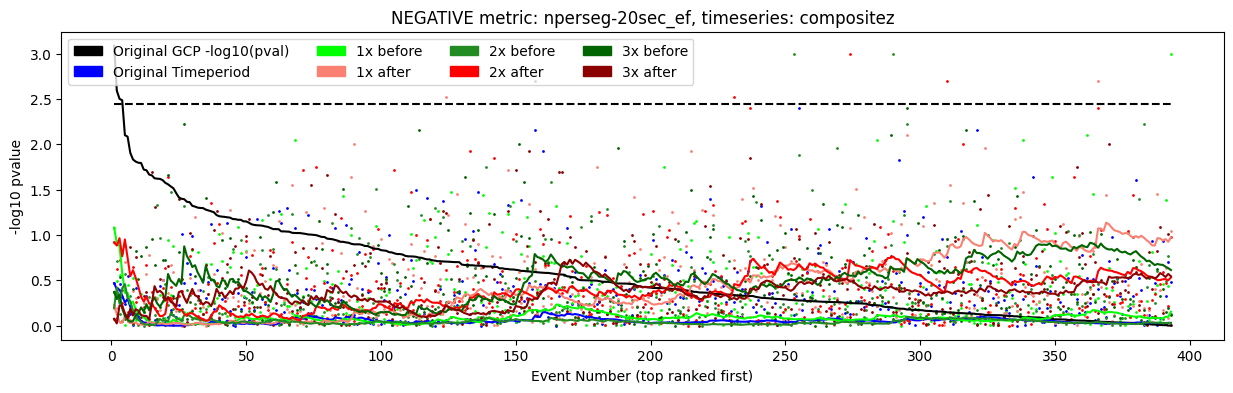

NEGATIVE nperseg-30sec_ef
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.8732253549290142
Rankbias p-value: Original Timeperiod pval: 0.3911143342305284
meta-analysis p-value: 1x before pval: 0.45310937812437513
Rankbias p-value: 1x before pval: 0.3898846625754795
meta-analysis p-value: 1x after pval: 0.4311137772445511
Rankbias p-value: 1x after pval: 0.7842676601882883
meta-analysis p-value: 2x before pval: 0.8504299140171966
Rankbias p-value: 2x before pval: 0.7105937761564618
meta-analysis p-value: 2x after pval: 0.40631873625274945
Rankbias p-value: 2x after pval: 0.2172090436983995
meta-analysis p-value: 3x before pval: 0.355128974205159
Rankbias p-value: 3x before pval: 0.8334559454369053
meta-analysis p-value: 3x after pval: 0.8078384323135372
Rankbias p-value: 3x after pval: 0.6963506519846365


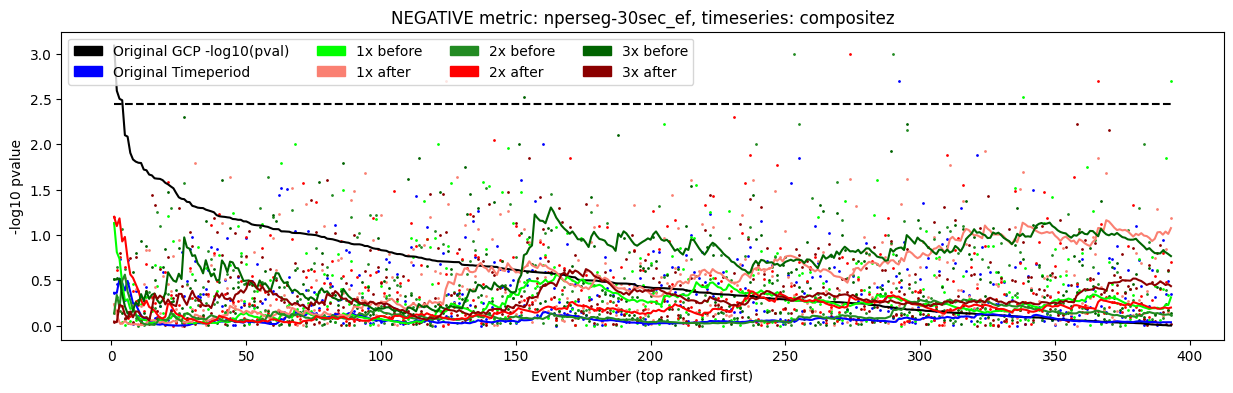

NEGATIVE nperseg-60sec_ef
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.8822235552889423
Rankbias p-value: Original Timeperiod pval: 0.3312039417819409
meta-analysis p-value: 1x before pval: 0.5900819836032793
Rankbias p-value: 1x before pval: 0.5513429693509625
meta-analysis p-value: 1x after pval: 0.39552089582083577
Rankbias p-value: 1x after pval: 0.8690981487598571
meta-analysis p-value: 2x before pval: 0.8052389522095581
Rankbias p-value: 2x before pval: 0.7171315063741329
meta-analysis p-value: 2x after pval: 0.5364927014597081
Rankbias p-value: 2x after pval: 0.19834331455308096
meta-analysis p-value: 3x before pval: 0.5474905018996201
Rankbias p-value: 3x before pval: 0.8771868260777513
meta-analysis p-value: 3x after pval: 0.8230353929214157
Rankbias p-value: 3x after pval: 0.6668018636917729


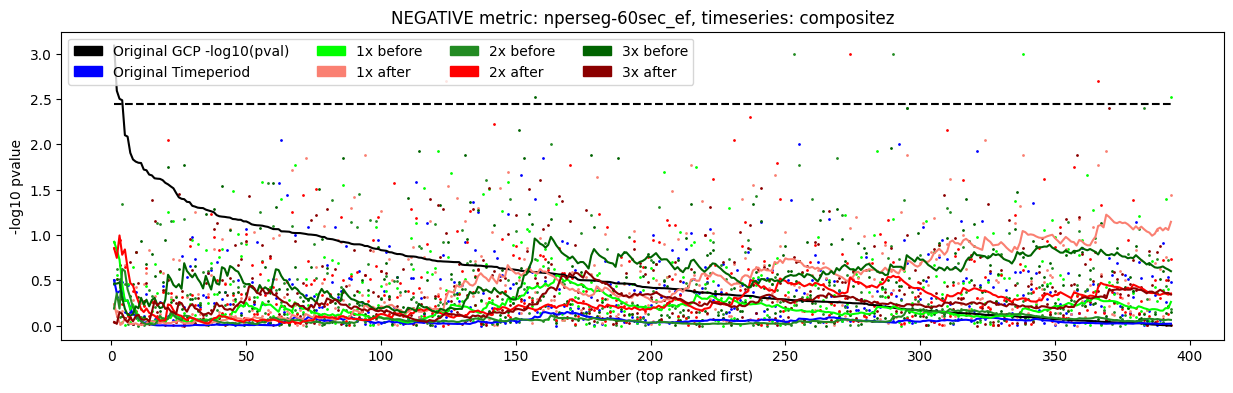

NEGATIVE nperseg-10sec_maxd
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.13717256548690263
Rankbias p-value: Original Timeperiod pval: 0.3983373856354708
meta-analysis p-value: 1x before pval: 0.364127174565087
Rankbias p-value: 1x before pval: 0.33669914232356224
meta-analysis p-value: 1x after pval: 0.0609878024395121
Rankbias p-value: 1x after pval: 0.957887914270421
meta-analysis p-value: 2x before pval: 0.78624275144971
Rankbias p-value: 2x before pval: 0.9340380748741888
meta-analysis p-value: 2x after pval: 0.8750249950009998
Rankbias p-value: 2x after pval: 0.07035514000499801
meta-analysis p-value: 3x before pval: 0.1965606878624275
Rankbias p-value: 3x before pval: 0.6550771185718204
meta-analysis p-value: 3x after pval: 0.1711657668466307
Rankbias p-value: 3x after pval: 0.8928049341078294


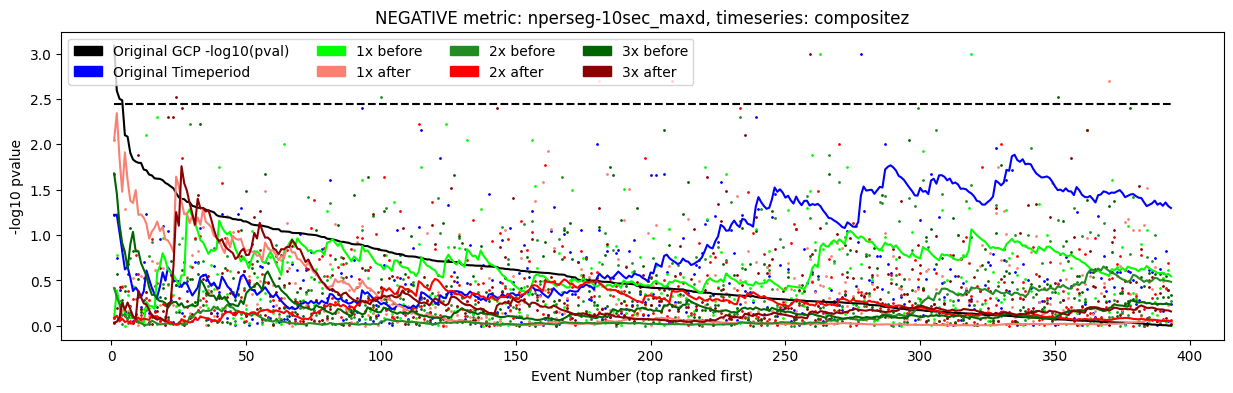

NEGATIVE nperseg-20sec_maxd
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.17556488702259548
Rankbias p-value: Original Timeperiod pval: 0.4289930881571654
meta-analysis p-value: 1x before pval: 0.9334133173365327
Rankbias p-value: 1x before pval: 0.6092370435389052
meta-analysis p-value: 1x after pval: 0.22155568886222757
Rankbias p-value: 1x after pval: 0.6136222098753062
meta-analysis p-value: 2x before pval: 0.052389522095580884
Rankbias p-value: 2x before pval: 0.7324062202480419
meta-analysis p-value: 2x after pval: 0.99500099980004
Rankbias p-value: 2x after pval: 0.5729823564817399
meta-analysis p-value: 3x before pval: 0.2483503299340132
Rankbias p-value: 3x before pval: 0.5569505168821279
meta-analysis p-value: 3x after pval: 0.6640671865626875
Rankbias p-value: 3x after pval: 0.9736953137660954


NEGATIVE nperseg-30sec_maxd
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.36172765446910615
Rankbias p-value: Original Timeperiod pval: 0.1977064172654759
meta-analysis p-value: 1x before pval: 0.9516096780643871
Rankbias p-value: 1x before pval: 0.3373676729467677
meta-analysis p-value: 1x after pval: 0.35132973405318935
Rankbias p-value: 1x after pval: 0.6762308394970714
meta-analysis p-value: 2x before pval: 0.35792841431713657
Rankbias p-value: 2x before pval: 0.6282471876472343
meta-analysis p-value: 2x after pval: 0.9874025194961008
Rankbias p-value: 2x after pval: 0.4985394220035642
meta-analysis p-value: 3x before pval: 0.5468906218756248
Rankbias p-value: 3x before pval: 0.5621859726656443
meta-analysis p-value: 3x after pval: 0.7960407918416317
Rankbias p-value: 3x after pval: 0.918268760796723


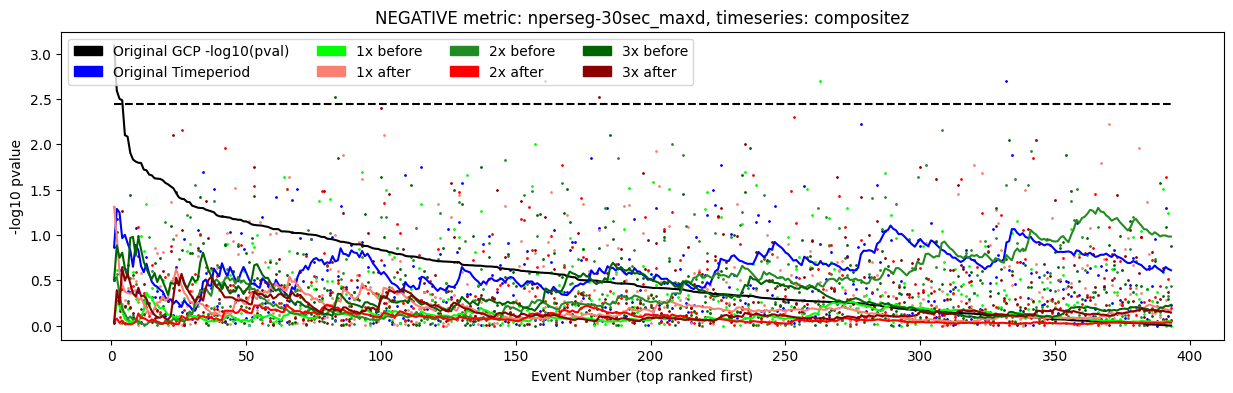

NEGATIVE nperseg-60sec_maxd
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.16756648670265947
Rankbias p-value: Original Timeperiod pval: 0.24779972307140685
meta-analysis p-value: 1x before pval: 0.9462107578484303
Rankbias p-value: 1x before pval: 0.6653030589703112
meta-analysis p-value: 1x after pval: 0.1869626074785043
Rankbias p-value: 1x after pval: 0.7850704488993135
meta-analysis p-value: 2x before pval: 0.6414717056588682
Rankbias p-value: 2x before pval: 0.8815964420210501
meta-analysis p-value: 2x after pval: 0.943011397720456
Rankbias p-value: 2x after pval: 0.16620097648739607
meta-analysis p-value: 3x before pval: 0.30553889222155567
Rankbias p-value: 3x before pval: 0.4861272538235825
meta-analysis p-value: 3x after pval: 0.8242351529694061
Rankbias p-value: 3x after pval: 0.9811524546847986


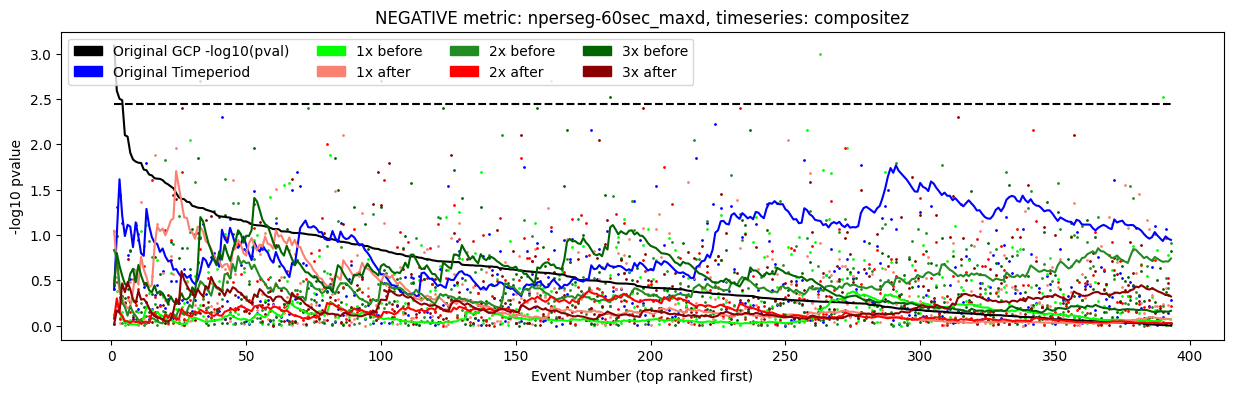

In [10]:
spannames = ['test', 'control1', 'control2', 'control3', 'control4', 'control5', 'control6']
loa_names = ['Original Timeperiod', '1x before', '1x after', '2x before', '2x after', '3x before', '3x after']
loa_colors = ['blue', 'lime', 'salmon', 'forestgreen', 'red', 'darkgreen', 'darkred']

all_metatrendplot_pvals = []

for signalname, pvals in [#('csm1', csm1_psanalysis),
                          ('compositez', compositez_psanalysis)
                          ]:
  print(signalname)
  npersegvals = ['10sec', '20sec', '30sec', '60sec']
  for metricname in ( ['nperseg-'+x+'_entropy' for x in npersegvals]+
                      ['nperseg-'+x+'_ef' for x in npersegvals]+
                      ['nperseg-'+x+'_maxd' for x in npersegvals]
                      ):
    print(metricname)
    pval_for_trendplots_list = make_meta_trend_plot(
      "metric: "+metricname+", timeseries: "+signalname,
      uncorrected_pvals_loa=[np.array([x["pval_"+metricname] for x in pvals[y]])
                             for y in spannames],
      loa_names=loa_names,
      loa_colors=loa_colors)
    for arr_name, pval in zip(loa_names, pval_for_trendplots_list):
      all_metatrendplot_pvals.append( ("span:"+arr_name+"; signal:"+signalname+"; metric:"+metricname,
                                       pval) )

for signalname, pvals in [#('csm1', csm1_psanalysis),
                          ('compositez', compositez_psanalysis)
                          ]:
  print(signalname)
  npersegvals = ['10sec', '20sec', '30sec', '60sec']
  for metricname in ( ['nperseg-'+x+'_entropy' for x in npersegvals]+
                      ['nperseg-'+x+'_ef' for x in npersegvals]+
                      ['nperseg-'+x+'_maxd' for x in npersegvals]
                      ):
    print("NEGATIVE", metricname)
    pval_for_trendplots_list = make_meta_trend_plot(
      "NEGATIVE metric: "+metricname+", timeseries: "+signalname,
      uncorrected_pvals_loa=[(1-np.array([x["pval_"+metricname] for x in pvals[y]]))
                             for y in spannames],
      loa_names=loa_names,
      loa_colors=loa_colors)
    for arr_name, pval in zip(loa_names, pval_for_trendplots_list):
      all_metatrendplot_pvals.append( ("span:"+arr_name+"; signal:"+signalname+"; metric:"+"negative-"+metricname,
                                       pval) )


In [11]:
[(x[0], x[1], (x[1]*len(all_metatrendplot_pvals) )/(i+1) )
  for (i,x) in enumerate(sorted(all_metatrendplot_pvals, key=lambda x: x[1]))]


[('span:2x before; signal:compositez; metric:nperseg-60sec_ef',
  0.01919616076784643,
  3.2249550089982),
 ('span:2x before; signal:compositez; metric:nperseg-10sec_ef',
  0.041591681663667265,
  3.4937012597480503),
 ('span:2x before; signal:compositez; metric:nperseg-30sec_ef',
  0.04879024195160968,
  2.732253549290142),
 ('span:2x before; signal:compositez; metric:negative-nperseg-20sec_maxd',
  0.052389522095580884,
  2.200359928014397),
 ('span:1x after; signal:compositez; metric:negative-nperseg-10sec_maxd',
  0.0609878024395121,
  2.0491901619676067),
 ('span:2x before; signal:compositez; metric:nperseg-20sec_ef',
  0.0649870025994801,
  1.8196360727854428),
 ('span:2x before; signal:compositez; metric:nperseg-20sec_entropy',
  0.06938612277544491,
  1.665266946610678),
 ('span:1x after; signal:compositez; metric:nperseg-20sec_entropy',
  0.07058588282343531,
  1.4823035392921415),
 ('span:Original Timeperiod; signal:compositez; metric:nperseg-60sec_entropy',
  0.1065786842631